Copyright 2020 Abhishek Dabas & Shruti Patil

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CO

# Abstract :
Image classification is a widely used and very meaningful task to train our deep learning models on. In this problem we have an input image with a label, from a fixed set of categories. This is one of the core problems in Computer Vision, and has very wide practical applications. In this notebook we will be using 5 CNN models to test it for Melnoma classification :
1. VGG16
1. VG19
1. ResNet50
1. InceptionV3
1. Xception

> We will be using **Transfer learning** for training these models. In the notebook we will be plotting the graphs and running the models for multiple  **epochs**.
>> We will running the CNN models on multiple hyperparameters and compare them with each other  
>>> We will be running the notebook on **TPU's** provided by Kaggle, for faster processing of the models. 


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

# Importing libraries

In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import cv2
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
from functools import partial
import sklearn
from tqdm import tqdm_notebook as tqdm
import gc
%matplotlib inline

# TPU Setup

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [8]:
print('Device:', tpu.master())
print('Number of replicas:', strategy.num_replicas_in_sync)
print("Version of Tensorflow used : ", tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
Version of Tensorflow used :  2.2.0


In [9]:
# Linking the TPU with KaggleDataset

AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]
SHAPE = [256, 256]

In [10]:
print("Batch Size = ", BATCH_SIZE)
print("GCS Path = ", GCS_PATH)

Batch Size =  128
GCS Path =  gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e


In [11]:
#read train data:
train = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/train.csv"))
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [12]:
#read test data
test = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/test.csv"))

test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

### Data types and null values check

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [15]:
train_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

In [16]:
image_names = train["image_name"].values + ".jpg"
random_images = [np.random.choice(image_names) for i in range(4)] # Generates a random sample from a given 1-D array
random_images 

['ISIC_5131914.jpg',
 'ISIC_2078787.jpg',
 'ISIC_9016941.jpg',
 'ISIC_1579497.jpg']

In [17]:
sample_images = []

Visualizing image data

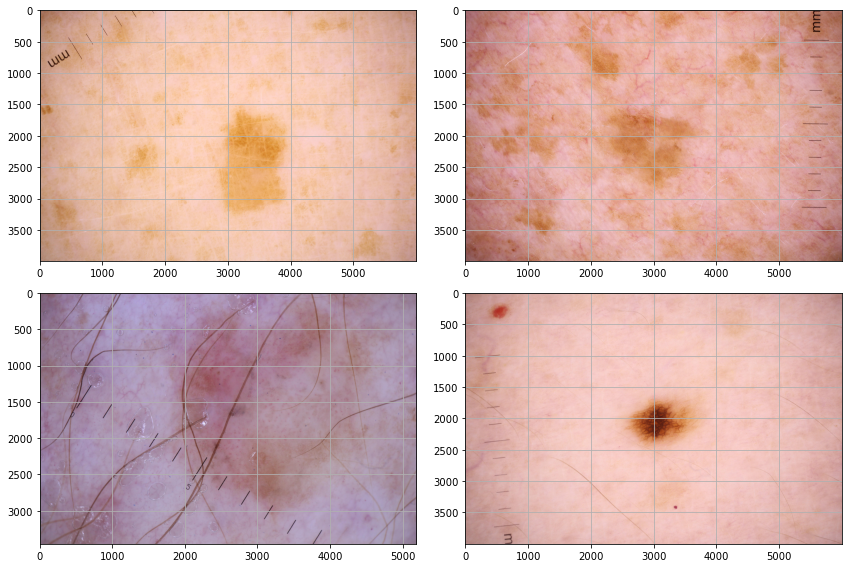

In [18]:
plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i + 1) 
    image = cv2.imread(os.path.join(train_dir, random_images[i]))
    # cv2 reads images in BGR format. Hence we convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample_images.append(image)
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

## OpenCV implementation of the aforementioned approach :
cv2.fastNlMeansDenoisingColored() - Works on Colored images cv2.fastNlMeansDenoising() - Works on graysacle images

Common arguments are:

* h : parameter deciding filter strength. Higher h value removes noise better, but removes details of image also. (10 is ok)
* hForColorComponents : same as h, but for color images only. (normally same as h)
* templateWindowSize : should be odd. (recommended 7)
* searchWindowSize : should be odd. (recommended 21)

In [19]:
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

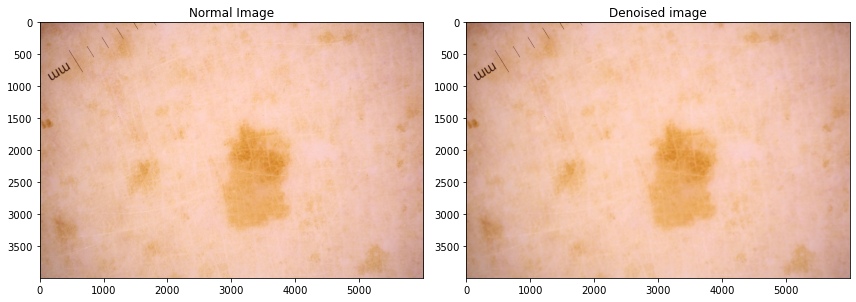

In [20]:
sample_image = cv2.imread(os.path.join(train_dir, random_images[0]))
# cv2 reads images in BGR format. Hence we convert it to RGB
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
denoised_image = non_local_means_denoising(sample_image)


plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image")

plt.subplot(1,2,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised image")    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout() 

In [21]:
def histogram_equalization(image) : 
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    y_channel = image_ycrcb[:,:,0] # apply local histogram processing on this channel
    cr_channel = image_ycrcb[:,:,1]
    cb_channel = image_ycrcb[:,:,2]
    
    # Local histogram equalization
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8,8))
    equalized = clahe.apply(y_channel)
    equalized_image = cv2.merge([equalized, cr_channel, cb_channel])
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YCR_CB2RGB)
    return equalized_image

In [22]:
equalized_image = histogram_equalization(denoised_image)

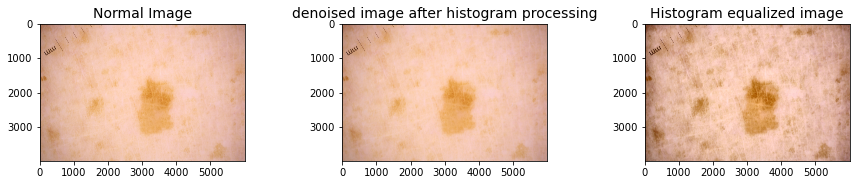

In [23]:
plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image", fontsize = 14)

plt.subplot(1,3,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("denoised image after histogram processing", fontsize = 14)

plt.subplot(1,3,3)  
plt.imshow(equalized_image, cmap = "gray")
plt.grid(False)
plt.title("Histogram equalized image", fontsize = 14)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

In [24]:
def segmentation(image, k, attempts) : 
    vectorized = np.float32(image.reshape((-1, 3)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    res , label , center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((image.shape))
    return segmented_image

Text(0.5, 1.0, 'de Noised Image')

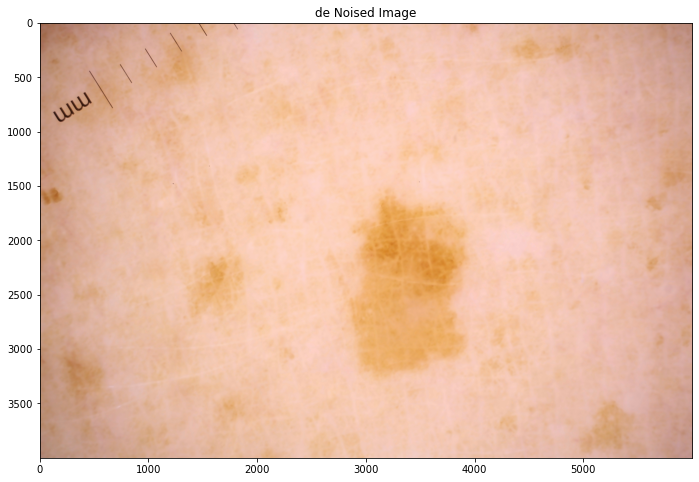

In [25]:
plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("de Noised Image")

Text(0.5, 1.0, 'Segmented Image with k = 5')

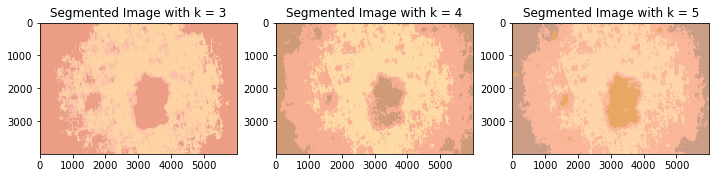

In [26]:
plt.figure(figsize = (12, 8))
segmented_image = segmentation(denoised_image, 3, 10) # k = 3, attempt = 10
plt.subplot(1,3,1)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 3")

segmented_image = segmentation(denoised_image, 4, 10) # k = 4, attempt = 10
plt.subplot(1,3,2)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 4")

segmented_image = segmentation(denoised_image, 5, 10) # k = 5, attempt = 10
plt.subplot(1,3,3)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 5")

In [27]:
from sklearn.model_selection import train_test_split 
training_files, validation_files = train_test_split(tf.io.gfile.glob(GCS_PATH + "/tfrecords/train*.tfrec"),
                                                   test_size = 0.1, random_state = 42)

testing_files = tf.io.gfile.glob(GCS_PATH + "/tfrecords/test*.tfrec")

print("Number of training files = ", len(training_files))
print("Number of validation files = ", len(validation_files))
print("Number of test files = ", len(testing_files))

Number of training files =  14
Number of validation files =  2
Number of test files =  16


In [28]:
def decode_image(image) : 
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.reshape(image, [IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    return image

In [29]:
sample_images[0].shape

(4000, 6000, 3)

We observe our training_files object stores all tfrecord files. Let's pick one to analyze. 

In [30]:
training_files

['gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train05-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train14-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train13-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train11-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train08-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train09-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train02-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train15-2061.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train04-2071.tfrec',
 'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train07-2071.tfrec',
 'gs://kds

In [31]:
sample_picked = training_files[0]
sample_picked

'gs://kds-0239565729562a730c95deb52d5a97593f6f7b73d0d8125d1ae74f7e/tfrecords/train05-2071.tfrec'

A TFRecord file can be read using **tf.data.TFRecordDataset** class.

In [32]:
file = tf.data.TFRecordDataset(sample_picked)
file

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [33]:
feature_description = {"image" : tf.io.FixedLenFeature([], tf.string), 
                      "target" : tf.io.FixedLenFeature([], tf.int64)}

In [34]:
def parse_function(example) : 
    # The example supplied is parsed based on the feature_description above.
    return tf.io.parse_single_example(example, feature_description)

In [35]:
parsed_dataset = file.map(parse_function)
parsed_dataset

<MapDataset shapes: {image: (), target: ()}, types: {image: tf.string, target: tf.int64}>

In [36]:
def read_tfrecord(example, labeled) : 
    if labeled == True : 
        tfrecord_format = {"image" : tf.io.FixedLenFeature([], tf.string),
                           "target" : tf.io.FixedLenFeature([], tf.int64)}
    else:
        tfrecord_format = {"image" : tf.io.FixedLenFeature([], tf.string),
                          "image_name" : tf.io.FixedLenFeature([], tf.string)}
    
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled == True : 
        label = tf.cast(example["target"], tf.int32)
        return image, label
    else:
        image_name = example["image_name"]
        return image, image_name     

In [37]:
def load_dataset(filenames, labeled, ordered):
    ignore_order = tf.data.Options()
    if ordered == False: # dataset is unordered, so we ignore the order to load data quickly.
        ignore_order.experimental_deterministic = False # This disables the order and enhances the speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) 
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [38]:
def image_augmentation(image, label) :     
    image = tf.image.resize(image, SHAPE)
    image = tf.image.random_flip_left_right(image)
    return image, label

# Load The Datasets : 

In [39]:
def get_training_dataset() : 
    dataset = load_dataset(training_files, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [40]:
def get_validation_dataset() : 
    dataset = load_dataset(validation_files, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [41]:
def get_test_dataset() : 
    dataset = load_dataset(testing_files, labeled = False, ordered = True)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [42]:
training_dataset = get_training_dataset()

In [43]:
validation_dataset = get_validation_dataset()

In [44]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

num_training_images = count_data_items(training_files)
num_validation_images = count_data_items(validation_files)
num_testing_images = count_data_items(testing_files)

# number of images/steps
STEPS_PER_EPOCH_TRAIN = num_training_images // BATCH_SIZE
STEPS_PER_EPOCH_VAL = num_validation_images // BATCH_SIZE

print("Number of Training Images = ", num_training_images)
print("Number of Validation Images = ", num_validation_images)
print("Number of Testing Images = ", num_testing_images)
print("\n")
print("Numer of steps per epoch in Train = ", STEPS_PER_EPOCH_TRAIN)
print("Numer of steps per epoch in Validation = ", STEPS_PER_EPOCH_VAL)

Number of Training Images =  28984
Number of Validation Images =  4142
Number of Testing Images =  10982


Numer of steps per epoch in Train =  226
Numer of steps per epoch in Validation =  32


In [45]:
image_batch, label_batch = next(iter(training_dataset))

In [46]:
def show_batch(image_batch, label_batch) :
    plt.figure(figsize = (20, 20))
    for n in range(8) : 
        ax = plt.subplot(2,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0 : 
            plt.title("BENIGN")
        else:
            plt.title("MALIGNANT")
    plt.grid(False)
    plt.tight_layout()       

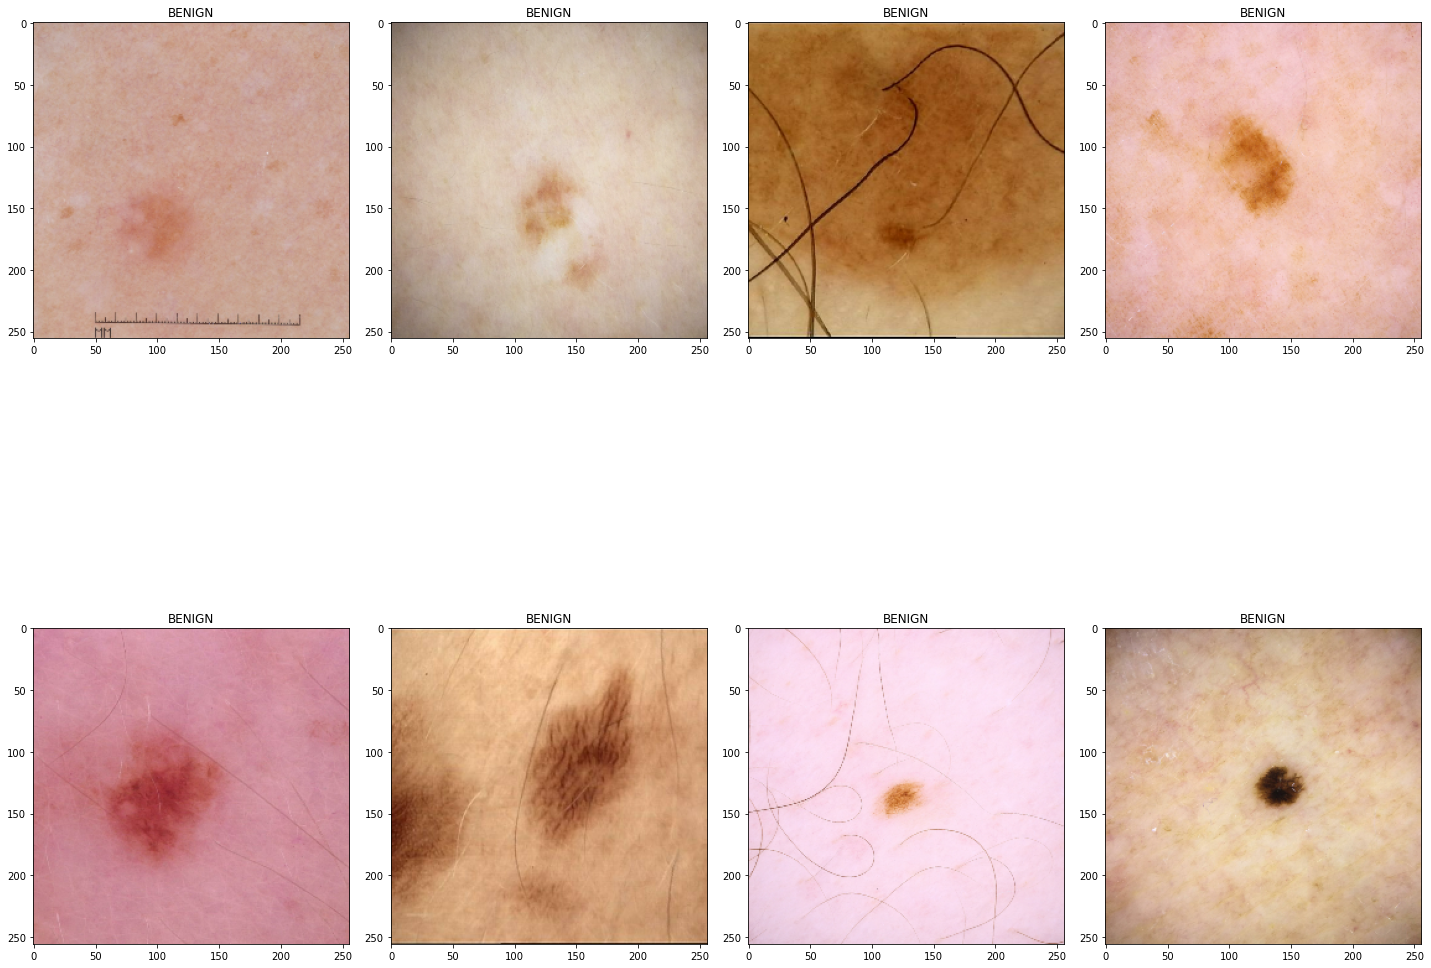

In [47]:
show_batch(image_batch.numpy(), label_batch.numpy())

Let's free up some memory

In [48]:
del image_batch
del label_batch
gc.collect()

17687

# Model Construction : 

## Malignant VS Benign Imbalance Analysis 

In [49]:
malignant = len(train[train["target"] == 1])
benign = len(train[train["target"] == 0 ])
total = len(train) 

print("Malignant Cases in Train Data = ", malignant)
print("Benign Cases In Train Dataset = ",benign)
print("Total Cases In Train Dataset = ",total)
print("Ratio of Malignant to Benign = ",malignant/benign)

Malignant Cases in Train Data =  584
Benign Cases In Train Dataset =  32542
Total Cases In Train Dataset =  33126
Ratio of Malignant to Benign =  0.017946038965029807


In [50]:
weight_malignant = (total/malignant)/2.0
weight_benign = (total/benign)/2.0

class_weight = {0 : weight_benign , 1 : weight_malignant}

print("Weight for benign cases = ", class_weight[0])
print("Weight for malignant cases = ", class_weight[1])

Weight for benign cases =  0.5089730194825149
Weight for malignant cases =  28.361301369863014


# defining the callbacks

In [51]:
# Stop training when a monitored metric has stopped improving.
callback_early_stopping = tf.keras.callbacks.EarlyStopping(patience = 15, verbose = 0, restore_best_weights = True)


#  Reduce learning rate when a metric has stopped improving.
callbacks_lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_auc", factor = 0.1, patience = 10, 
                                                          verbose = 0, min_lr = 1e-6)

# Callback to save the Keras model or model weights at some frequency. 
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint("melanoma_weights.h5",
                                                         save_weights_only=True, monitor='val_auc',
                                                         mode='max', save_best_only = True)

In [52]:
#hyperparameters:
epoch = [50, 100, 200]
#STEPS_PER_EPOCH_TRAIN= 100
#STEPS_PER_EPOCH_VAL= 100

## VGG16:

In [53]:
# building the model

with strategy.scope() : 
    bias = np.log(malignant/benign)
    bias = tf.keras.initializers.Constant(bias)
    base_model = tf.keras.applications.VGG16(input_shape = (SHAPE[0], SHAPE[1], 3), include_top = False,
                                               weights = "imagenet")
    base_model.trainable = False
    model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dense(20, activation = "relu"),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(10, activation = "relu"),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)                                     
                                ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-2), loss = "binary_crossentropy", metrics = [tf.keras.metrics.AUC(name = 'auc')])
    model.summary()
    
    

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                10260     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________

In [54]:
#creating an empty list to store VGG16 results
result_VGG =[]

In [55]:
# training the model
for i in range(len(epoch)):
    history = model.fit(training_dataset, epochs = epoch[i], steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
                       validation_data = validation_dataset, validation_steps = STEPS_PER_EPOCH_VAL,
                       callbacks = [callback_early_stopping, callbacks_lr_reduce, callback_checkpoint],
                       class_weight = class_weight)
    result_VGG.append(history)

Epoch 1/50
226/226 [==============================] - 44s 193ms/step - loss: 1.0011 - auc: 0.5343 - val_loss: 0.3750 - val_auc: 0.7164 - lr: 0.0100
Epoch 2/50
226/226 [==============================] - 28s 122ms/step - loss: 0.7606 - auc: 0.5572 - val_loss: 0.4884 - val_auc: 0.6455 - lr: 0.0100
Epoch 3/50
226/226 [==============================] - 28s 123ms/step - loss: 0.7225 - auc: 0.5545 - val_loss: 0.4948 - val_auc: 0.6594 - lr: 0.0100
Epoch 4/50
226/226 [==============================] - 26s 114ms/step - loss: 0.6986 - auc: 0.5825 - val_loss: 0.5193 - val_auc: 0.6920 - lr: 0.0100
Epoch 5/50
226/226 [==============================] - 27s 120ms/step - loss: 0.6825 - auc: 0.5979 - val_loss: 0.4966 - val_auc: 0.5264 - lr: 0.0100
Epoch 6/50
226/226 [==============================] - 25s 111ms/step - loss: 0.6834 - auc: 0.5952 - val_loss: 0.4863 - val_auc: 0.5973 - lr: 0.0100
Epoch 7/50
226/226 [==============================] - 25s 111ms/step - loss: 0.6705 - auc: 0.6066 - val_loss: 0.

In [56]:
#n_epochs_it_ran_for = len(history.history['loss'])
#n_epochs_it_ran_for

In [57]:
result_VGG[i].history["loss"]

[0.70802241563797,
 0.7168606519699097,
 0.7186654806137085,
 0.7160795331001282,
 0.7432404160499573,
 0.7275794744491577,
 0.7316293120384216,
 0.7323174476623535,
 0.7361311316490173,
 0.730427086353302,
 0.7018842697143555,
 0.7110360860824585,
 0.7156862616539001,
 0.7299946546554565,
 0.7022420763969421,
 0.7166712880134583]

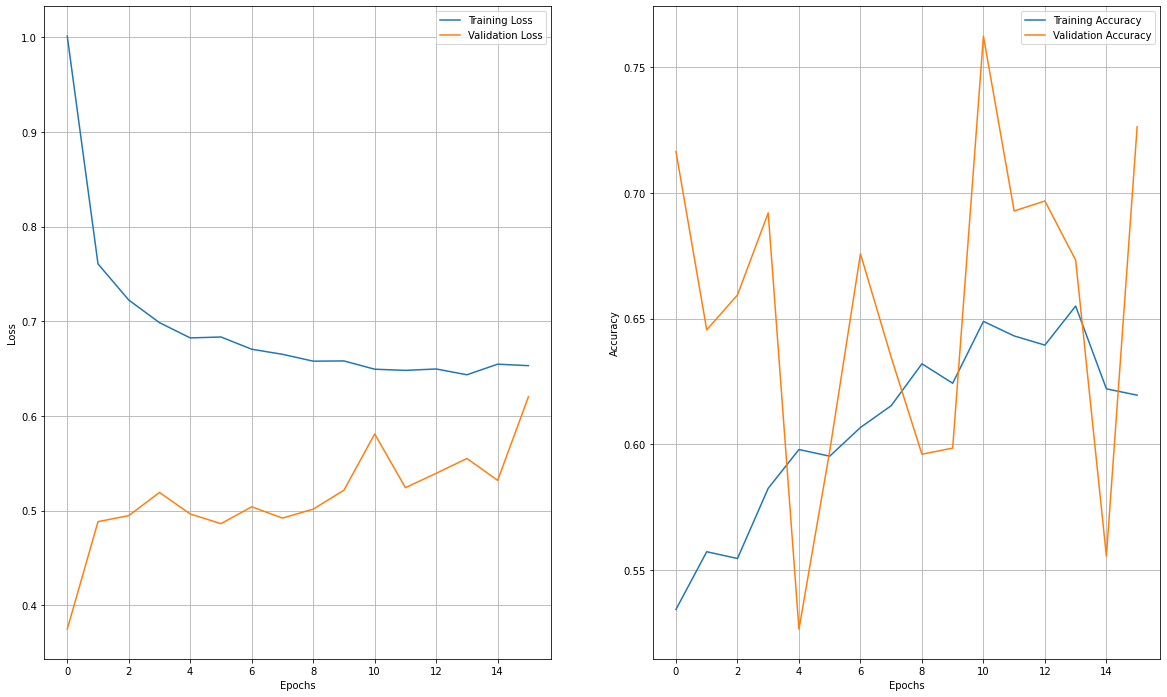

In [58]:
# graph for epoch = 50
a= 0

# plotting the graph
X = np.arange(0,len(result_VGG[0].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_VGG[0].history["loss"], label = "Training Loss")
plt.plot(X, result_VGG[0].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_VGG[0].history["auc"], label = "Training Accuracy")
plt.plot(X, result_VGG[0].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

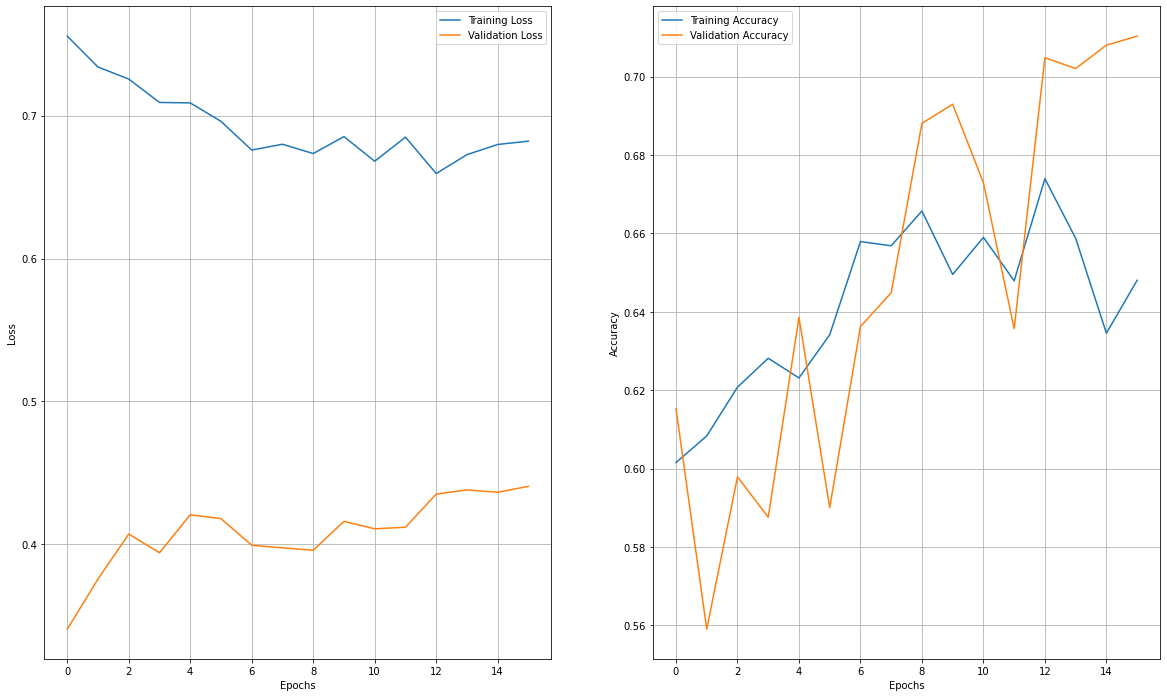

In [59]:
# Result for epoch = 100
a=1

# plotting the graph
X = np.arange(0,len(result_VGG[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_VGG[a].history["loss"], label = "Training Loss")
plt.plot(X, result_VGG[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_VGG[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_VGG[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

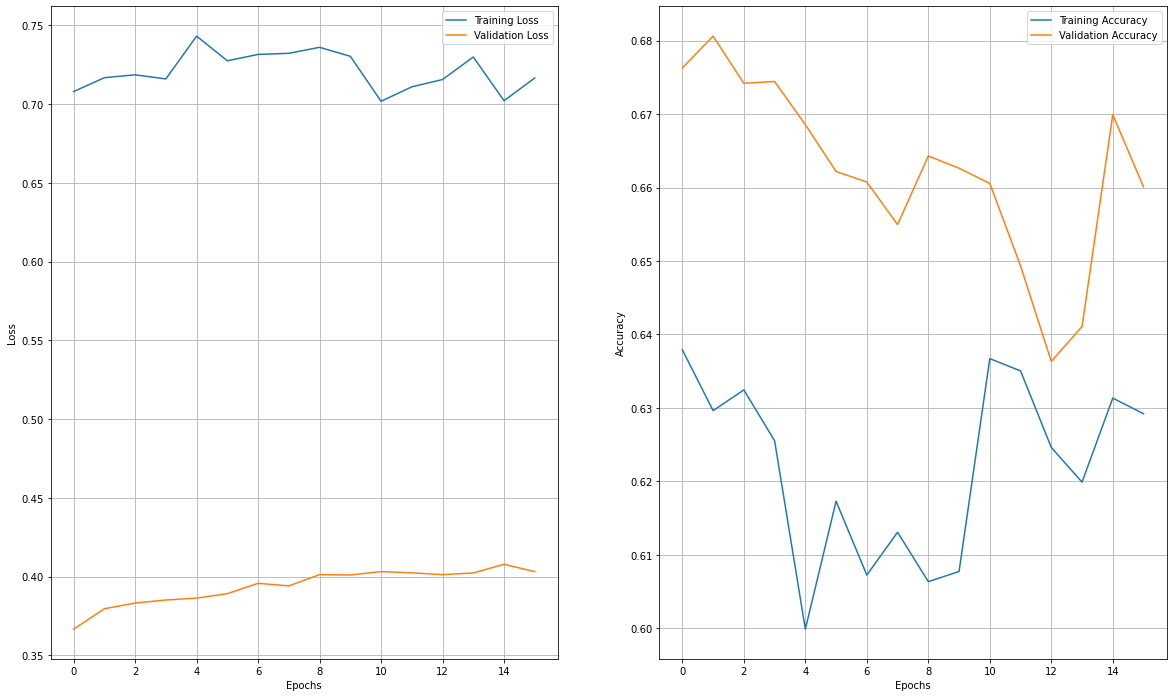

In [60]:
# Result for epoch = 200
a=2

# plotting the graph
X = np.arange(0,len(result_VGG[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_VGG[a].history["loss"], label = "Training Loss")
plt.plot(X, result_VGG[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_VGG[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_VGG[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [61]:
#def plot_training(history):
#    acc = history.history["auc"]
#    val_acc = history.history["val_auc"]
#    loss = history.history["loss"]
#    val_loss = history.history["val_loss"]
#    epochs = range(len(acc))

#    plt.plot(epochs, acc, 'b-')
#    plt.plot(epochs, val_acc, 'r')
#    plt.title('Training and validation accuracy')

#    plt.figure()
#    plt.plot(epochs, loss, 'b-')
#    plt.plot(epochs, val_loss, 'r-')
#    plt.title('Training and validation loss')
#    plt.show()
#    plot_training(history)

In [62]:
#plot_training(result_VGG[0])

### VGG19

In [63]:
# building the model
with strategy.scope() : 
    bias = np.log(malignant/benign)
    bias = tf.keras.initializers.Constant(bias)
    base_model = tf.keras.applications.VGG19(input_shape = (SHAPE[0], SHAPE[1], 3), include_top = False,
                                               weights = "imagenet")
    base_model.trainable = False
    model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dense(20, activation = "relu"),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(10, activation = "relu"),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)                                     
                                ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-2), loss = "binary_crossentropy", metrics = [tf.keras.metrics.AUC(name = 'auc')])
    model.summary()
    
    

80142336/80134624 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                10260     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_______________________________________________________

In [64]:
result_VGG19 =[]

In [65]:
# training the model
for i in range(len(epoch)):
    history = model.fit(training_dataset, epochs = epoch[i], steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
                       validation_data = validation_dataset, validation_steps = STEPS_PER_EPOCH_VAL,
                       callbacks = [callback_early_stopping, callbacks_lr_reduce, callback_checkpoint],
                       class_weight = class_weight)
    result_VGG19.append(history)

Epoch 1/50
226/226 [==============================] - 33s 147ms/step - loss: 0.9607 - auc: 0.5561 - val_loss: 0.3898 - val_auc: 0.7310 - lr: 0.0100
Epoch 2/50
226/226 [==============================] - 26s 115ms/step - loss: 0.7560 - auc: 0.6055 - val_loss: 0.3820 - val_auc: 0.7416 - lr: 0.0100
Epoch 3/50
226/226 [==============================] - 27s 121ms/step - loss: 0.7303 - auc: 0.5428 - val_loss: 0.4969 - val_auc: 0.5693 - lr: 0.0100
Epoch 4/50
226/226 [==============================] - 25s 111ms/step - loss: 0.7038 - auc: 0.5558 - val_loss: 0.6226 - val_auc: 0.7094 - lr: 0.0100
Epoch 5/50
226/226 [==============================] - 24s 108ms/step - loss: 0.6813 - auc: 0.6042 - val_loss: 0.4803 - val_auc: 0.7119 - lr: 0.0100
Epoch 6/50
226/226 [==============================] - 24s 108ms/step - loss: 0.6672 - auc: 0.6269 - val_loss: 0.4484 - val_auc: 0.6845 - lr: 0.0100
Epoch 7/50
226/226 [==============================] - 25s 110ms/step - loss: 0.6607 - auc: 0.6347 - val_loss: 0.

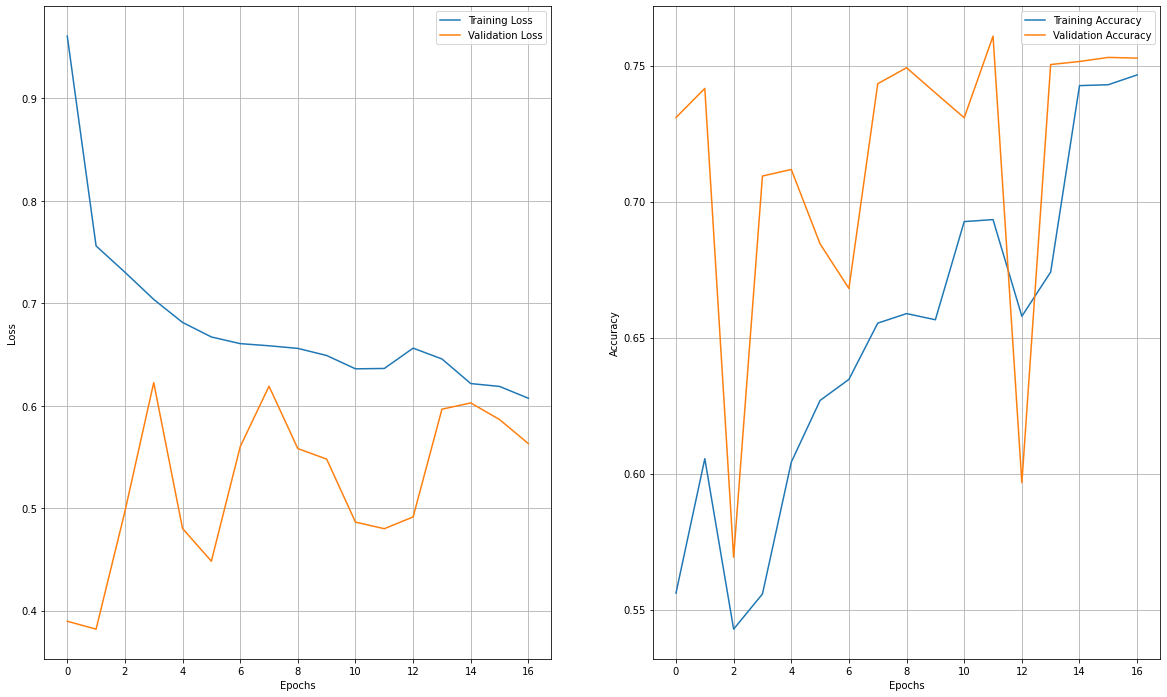

In [66]:
# Result for epoch = 50
a=0

# plotting the graph
X = np.arange(0,len(result_VGG19[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_VGG19[a].history["loss"], label = "Training Loss")
plt.plot(X, result_VGG19[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_VGG19[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_VGG19[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

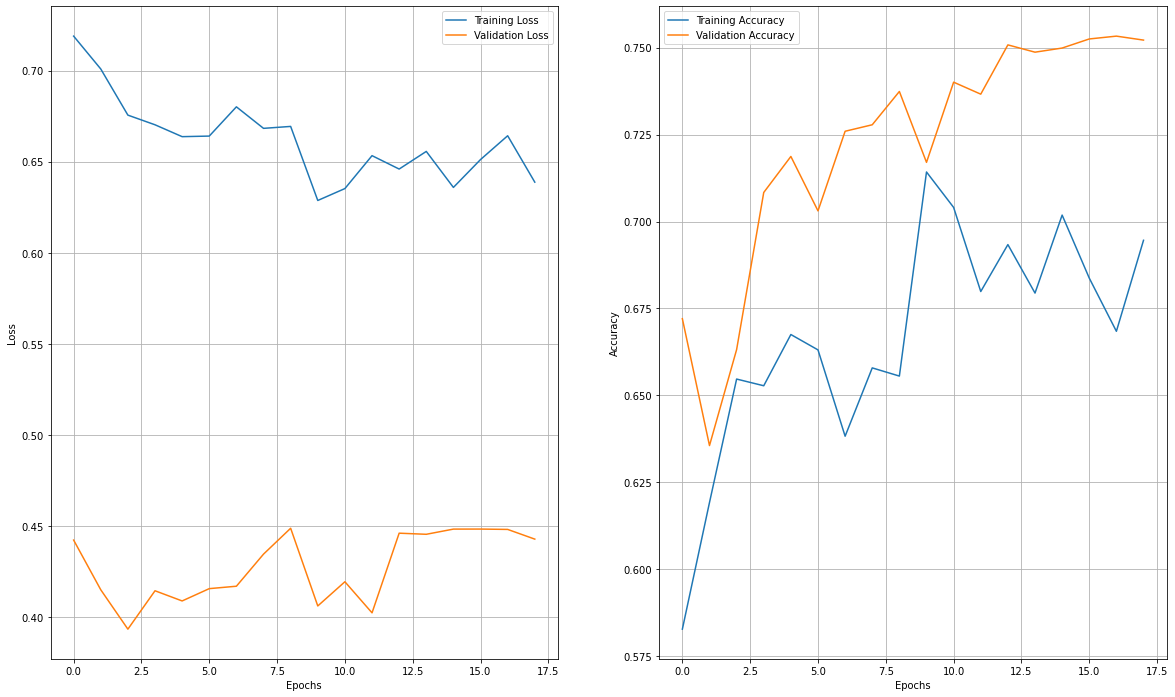

In [67]:
# Result for epoch = 100
a=1

# plotting the graph
X = np.arange(0,len(result_VGG19[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_VGG19[a].history["loss"], label = "Training Loss")
plt.plot(X, result_VGG19[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_VGG19[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_VGG19[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

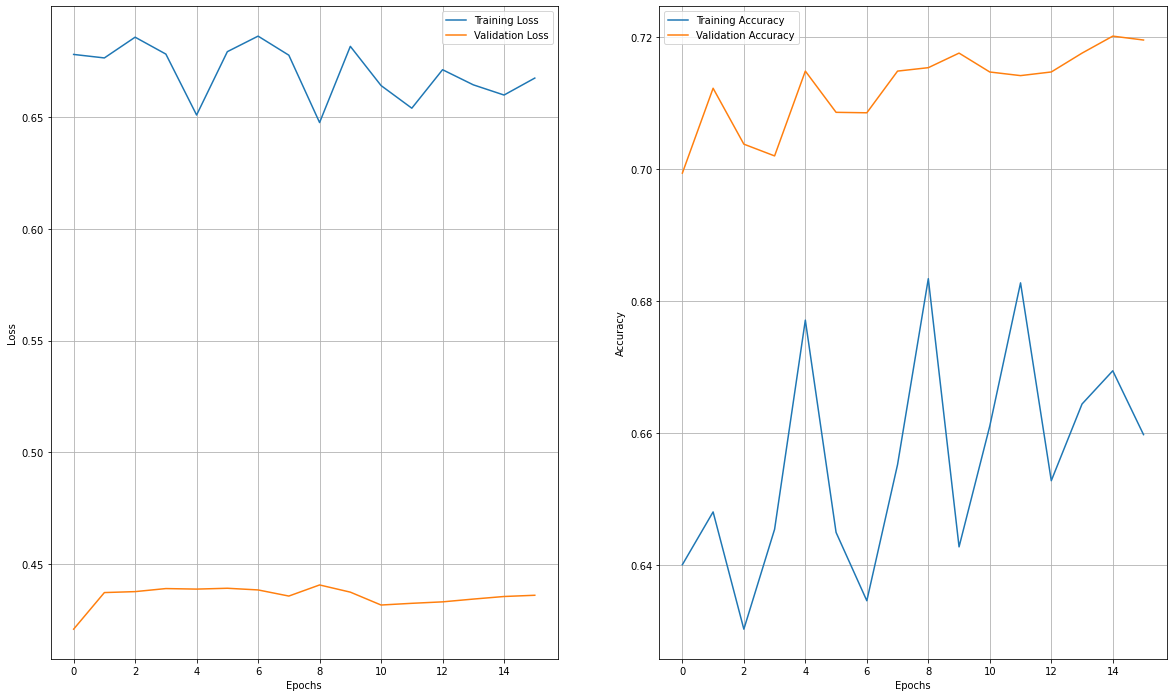

In [68]:
# Result for epoch = 200
a=2

# plotting the graph
X = np.arange(0,len(result_VGG19[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_VGG19[a].history["loss"], label = "Training Loss")
plt.plot(X, result_VGG19[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_VGG19[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_VGG19[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

## ResNet50

In [69]:
# building the model
with strategy.scope() : 
    bias = np.log(malignant/benign)
    bias = tf.keras.initializers.Constant(bias)
    base_model = tf.keras.applications.ResNet50(input_shape = (SHAPE[0], SHAPE[1], 3), include_top = False,
                                               weights = "imagenet")
    base_model.trainable = False
    model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dense(20, activation = "relu"),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(10, activation = "relu"),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)                                     
                                ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-2), loss = "binary_crossentropy", metrics = [tf.keras.metrics.AUC(name = 'auc')])
    model.summary()
    
    

94773248/94765736 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                40980     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_______________________________________________________

In [70]:
result_ResNet50 =[]

In [71]:
# training the model
for i in range(len(epoch)):
    history = model.fit(training_dataset, epochs = epoch[i], steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
                       validation_data = validation_dataset, validation_steps = STEPS_PER_EPOCH_VAL,
                       callbacks = [callback_early_stopping, callbacks_lr_reduce, callback_checkpoint],
                       class_weight = class_weight)
    result_ResNet50.append(history)

Epoch 1/50
226/226 [==============================] - 39s 171ms/step - loss: 1.0297 - auc: 0.5117 - val_loss: 0.5095 - val_auc: 0.5000 - lr: 0.0100
Epoch 2/50
226/226 [==============================] - 26s 115ms/step - loss: 0.7804 - auc: 0.4984 - val_loss: 0.5295 - val_auc: 0.5000 - lr: 0.0100
Epoch 3/50
226/226 [==============================] - 27s 119ms/step - loss: 0.7604 - auc: 0.4843 - val_loss: 0.5345 - val_auc: 0.5000 - lr: 0.0100
Epoch 4/50
226/226 [==============================] - 25s 112ms/step - loss: 0.7474 - auc: 0.4749 - val_loss: 0.5362 - val_auc: 0.5000 - lr: 0.0100
Epoch 5/50
226/226 [==============================] - 26s 114ms/step - loss: 0.7324 - auc: 0.4878 - val_loss: 0.5579 - val_auc: 0.5000 - lr: 0.0100
Epoch 6/50
226/226 [==============================] - 25s 111ms/step - loss: 0.7190 - auc: 0.5051 - val_loss: 0.5934 - val_auc: 0.5000 - lr: 0.0100
Epoch 7/50
226/226 [==============================] - 24s 107ms/step - loss: 0.7106 - auc: 0.5027 - val_loss: 0.

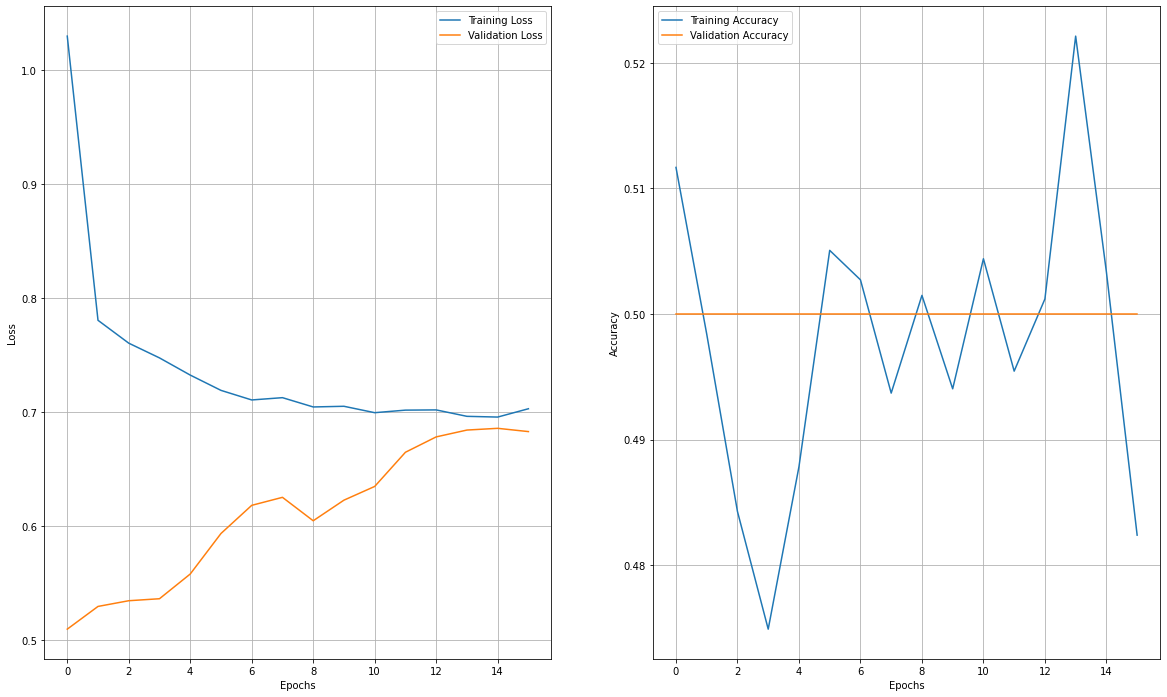

In [72]:
# Result for epoch = 50
a=0

# plotting the graph
X = np.arange(0,len(result_ResNet50[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_ResNet50[a].history["loss"], label = "Training Loss")
plt.plot(X, result_ResNet50[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_ResNet50[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_ResNet50[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

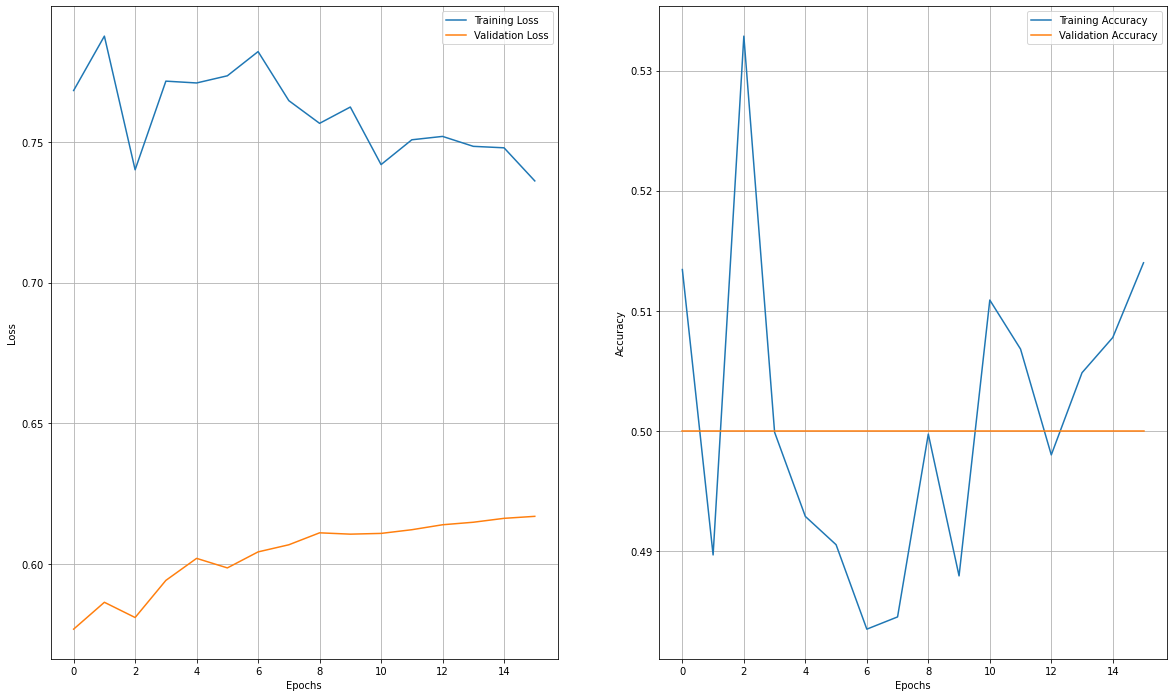

In [73]:
# Result for epoch = 100
a=1

# plotting the graph

X = np.arange(0,len(result_ResNet50[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_ResNet50[a].history["loss"], label = "Training Loss")
plt.plot(X, result_ResNet50[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_ResNet50[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_ResNet50[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

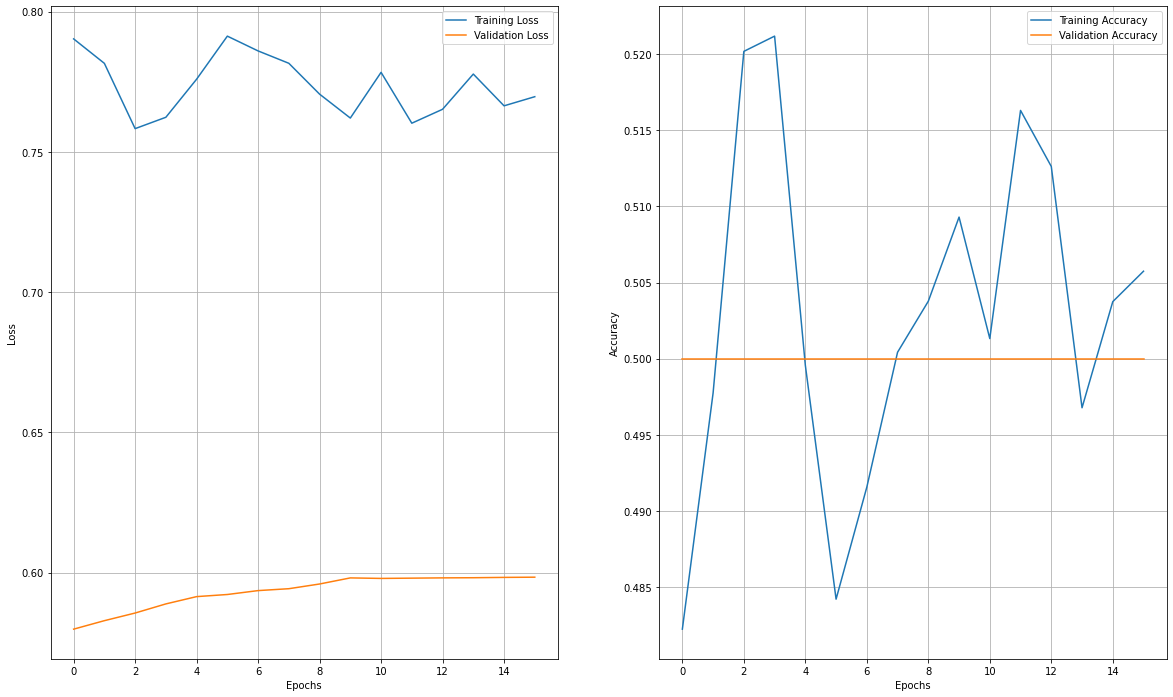

In [74]:
# Result for epoch = 200
a=2

# plotting the graph

X = np.arange(0,len(result_ResNet50[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_ResNet50[a].history["loss"], label = "Training Loss")
plt.plot(X, result_ResNet50[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_ResNet50[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_ResNet50[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

## InceptionV3 

In [75]:
# building the model
with strategy.scope() : 
    bias = np.log(malignant/benign)
    bias = tf.keras.initializers.Constant(bias)
    base_model = tf.keras.applications.InceptionV3(input_shape = (SHAPE[0], SHAPE[1], 3), include_top = False,
                                               weights = "imagenet")
    base_model.trainable = False
    model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dense(20, activation = "relu"),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(10, activation = "relu"),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)                                     
                                ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-2), loss = "binary_crossentropy", metrics = [tf.keras.metrics.AUC(name = 'auc')])
    model.summary()
    
    

87916544/87910968 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                40980     
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_______________________________________________________

In [76]:
result_InceptionV3 =[]

In [77]:
# training the model
for i in range(len(epoch)):
    history = model.fit(training_dataset, epochs = epoch[i], steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
                       validation_data = validation_dataset, validation_steps = STEPS_PER_EPOCH_VAL,
                       callbacks = [callback_early_stopping, callbacks_lr_reduce, callback_checkpoint],
                       class_weight = class_weight)
    result_InceptionV3.append(history)

Epoch 1/50
226/226 [==============================] - 47s 209ms/step - loss: 1.1268 - auc: 0.5981 - val_loss: 0.3697 - val_auc: 0.7366 - lr: 0.0100
Epoch 2/50
226/226 [==============================] - 29s 128ms/step - loss: 0.7056 - auc: 0.6563 - val_loss: 0.4405 - val_auc: 0.8322 - lr: 0.0100
Epoch 3/50
226/226 [==============================] - 29s 130ms/step - loss: 0.7450 - auc: 0.5325 - val_loss: 0.5427 - val_auc: 0.5000 - lr: 0.0100
Epoch 4/50
226/226 [==============================] - 29s 128ms/step - loss: 0.7337 - auc: 0.4888 - val_loss: 0.5539 - val_auc: 0.5000 - lr: 0.0100
Epoch 5/50
226/226 [==============================] - 29s 130ms/step - loss: 0.7142 - auc: 0.5164 - val_loss: 0.5663 - val_auc: 0.5000 - lr: 0.0100
Epoch 6/50
226/226 [==============================] - 29s 130ms/step - loss: 0.7220 - auc: 0.4871 - val_loss: 0.5866 - val_auc: 0.5000 - lr: 0.0100
Epoch 7/50
226/226 [==============================] - 29s 128ms/step - loss: 0.7109 - auc: 0.5022 - val_loss: 0.

Epoch 12/200
226/226 [==============================] - 32s 140ms/step - loss: 0.5997 - auc: 0.7595 - val_loss: 0.2978 - val_auc: 0.8329 - lr: 1.0000e-06
Epoch 13/200
226/226 [==============================] - 29s 129ms/step - loss: 0.5901 - auc: 0.7661 - val_loss: 0.2979 - val_auc: 0.8325 - lr: 1.0000e-06
Epoch 14/200
226/226 [==============================] - 30s 131ms/step - loss: 0.6058 - auc: 0.7569 - val_loss: 0.2980 - val_auc: 0.8328 - lr: 1.0000e-06
Epoch 15/200
226/226 [==============================] - 32s 143ms/step - loss: 0.5958 - auc: 0.7642 - val_loss: 0.2981 - val_auc: 0.8339 - lr: 1.0000e-06
Epoch 16/200
226/226 [==============================] - 33s 145ms/step - loss: 0.6027 - auc: 0.7562 - val_loss: 0.2981 - val_auc: 0.8339 - lr: 1.0000e-06


# Plotting the result for InceptionV3 Model

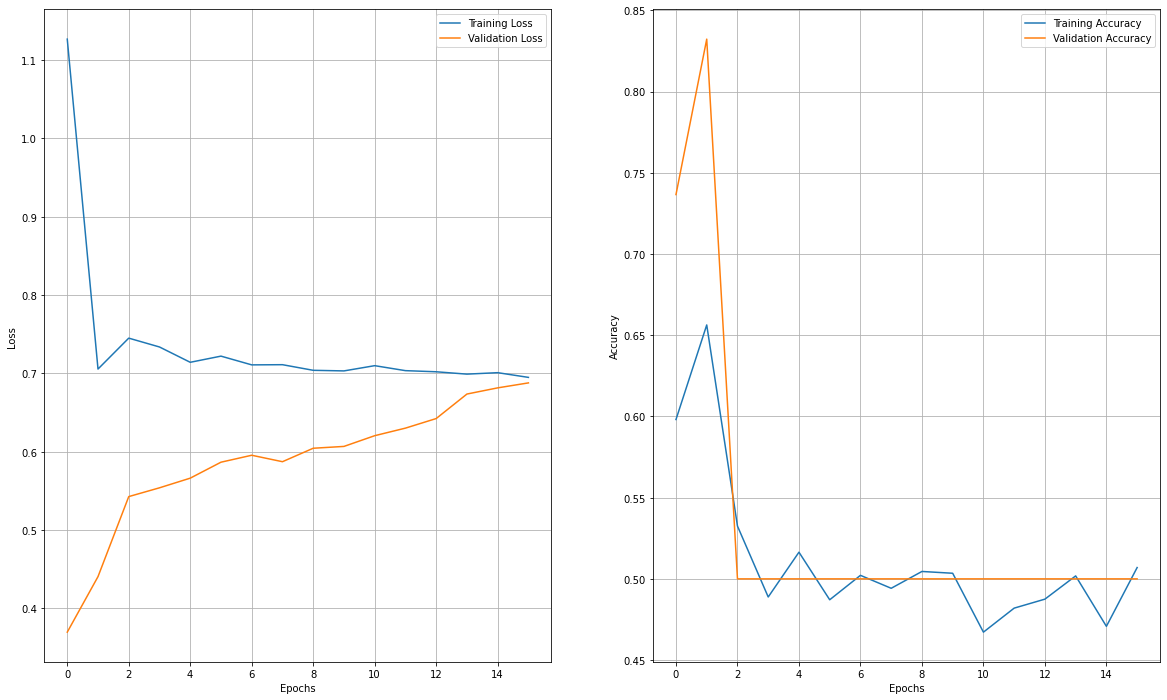

In [78]:
# Result for epoch = 50
a=0

# plotting the graph
X = np.arange(0,len(result_InceptionV3[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_InceptionV3[a].history["loss"], label = "Training Loss")
plt.plot(X, result_InceptionV3[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_InceptionV3[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_InceptionV3[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

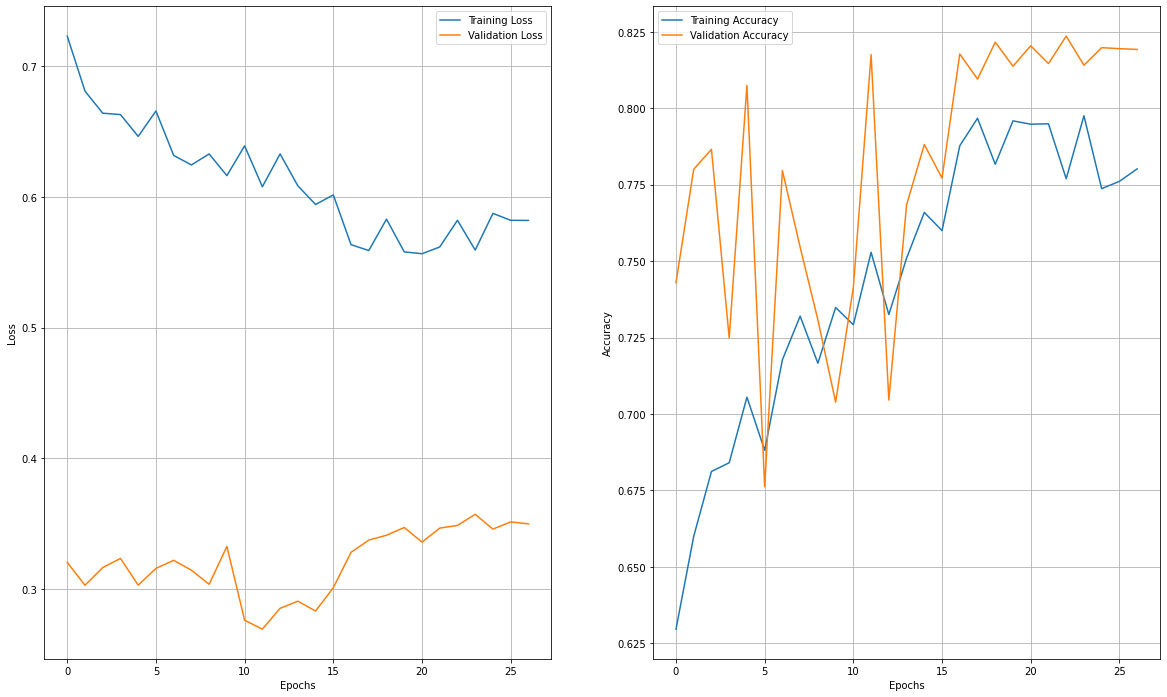

In [79]:
# Result for epoch = 100
a=1

# plotting the graph
X = np.arange(0,len(result_InceptionV3[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_InceptionV3[a].history["loss"], label = "Training Loss")
plt.plot(X, result_InceptionV3[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_InceptionV3[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_InceptionV3[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

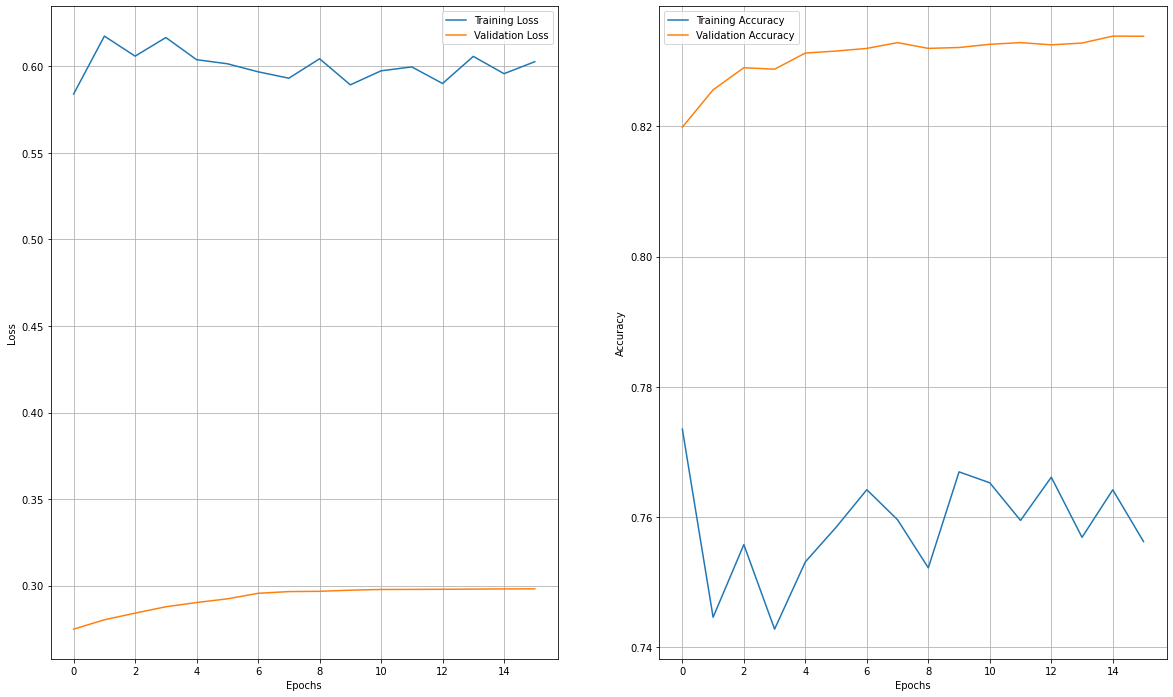

In [80]:
# Result for epoch = 200
a=2

# plotting the graph

X = np.arange(0,len(result_InceptionV3[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_InceptionV3[a].history["loss"], label = "Training Loss")
plt.plot(X, result_InceptionV3[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_InceptionV3[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_InceptionV3[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

## Xception:


In [81]:
# defining the Xception model 

with strategy.scope() : 
    bias = np.log(malignant/benign)
    bias = tf.keras.initializers.Constant(bias)
    base_model = tf.keras.applications.Xception(input_shape = (SHAPE[0], SHAPE[1], 3), include_top = False,
                                               weights = "imagenet")
    base_model.trainable = False
    model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dense(20, activation = "relu"),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(10, activation = "relu"),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)                                     
                                ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-2), loss = "binary_crossentropy", metrics = [tf.keras.metrics.AUC(name = 'auc')])
    model.summary()
    
    

83689472/83683744 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                40980     
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_______________________________________________________

In [82]:
result_Xception =[]

In [83]:
# Training the model
for i in range(len(epoch)):
    history = model.fit(training_dataset, epochs = epoch[i], steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
                       validation_data = validation_dataset, validation_steps = STEPS_PER_EPOCH_VAL,
                       callbacks = [callback_early_stopping, callbacks_lr_reduce, callback_checkpoint],
                       class_weight = class_weight)
    result_Xception.append(history)

Epoch 1/50
226/226 [==============================] - 39s 171ms/step - loss: 1.2193 - auc: 0.4909 - val_loss: 0.4395 - val_auc: 0.5000 - lr: 0.0100
Epoch 2/50
226/226 [==============================] - 26s 115ms/step - loss: 0.8424 - auc: 0.4940 - val_loss: 0.4710 - val_auc: 0.5000 - lr: 0.0100
Epoch 3/50
226/226 [==============================] - 28s 124ms/step - loss: 0.7795 - auc: 0.5078 - val_loss: 0.5023 - val_auc: 0.5000 - lr: 0.0100
Epoch 4/50
226/226 [==============================] - 26s 114ms/step - loss: 0.7578 - auc: 0.4989 - val_loss: 0.5676 - val_auc: 0.5000 - lr: 0.0100
Epoch 5/50
226/226 [==============================] - 26s 117ms/step - loss: 0.7185 - auc: 0.5178 - val_loss: 0.5814 - val_auc: 0.5000 - lr: 0.0100
Epoch 6/50
226/226 [==============================] - 25s 110ms/step - loss: 0.7145 - auc: 0.5073 - val_loss: 0.5974 - val_auc: 0.5000 - lr: 0.0100
Epoch 7/50
226/226 [==============================] - 25s 111ms/step - loss: 0.7139 - auc: 0.4819 - val_loss: 0.

# Plotting the results for Xception Model

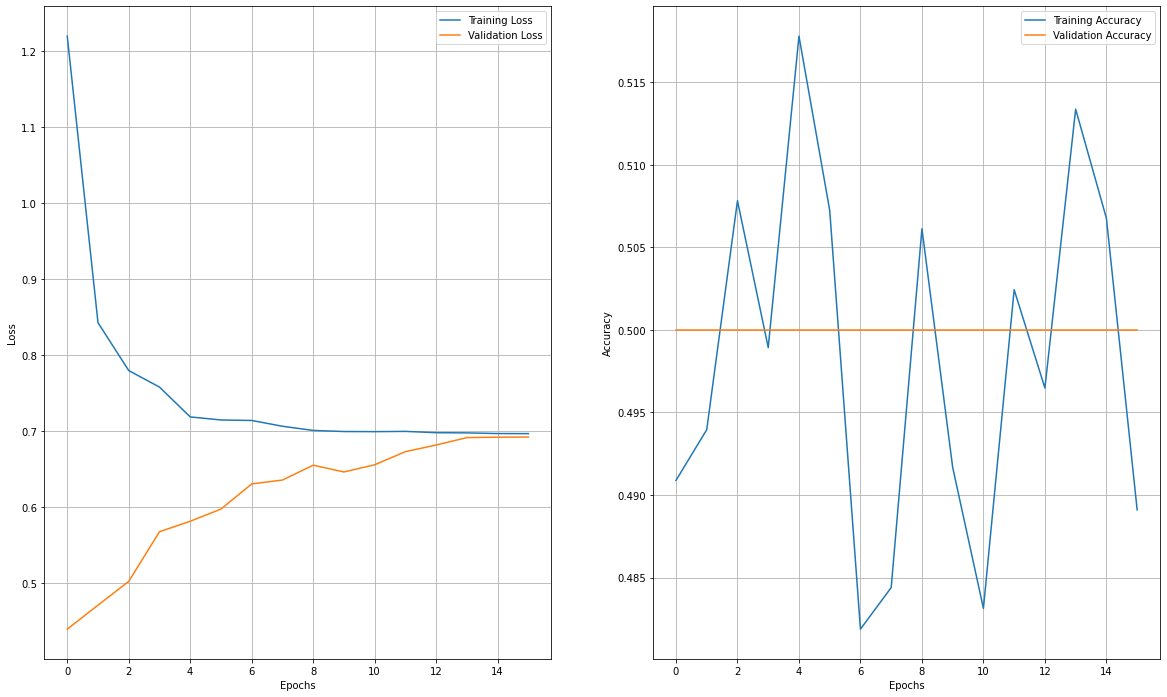

In [84]:
a=0
X = np.arange(0,len(result_Xception[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_Xception[a].history["loss"], label = "Training Loss")
plt.plot(X, result_Xception[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_Xception[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_Xception[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

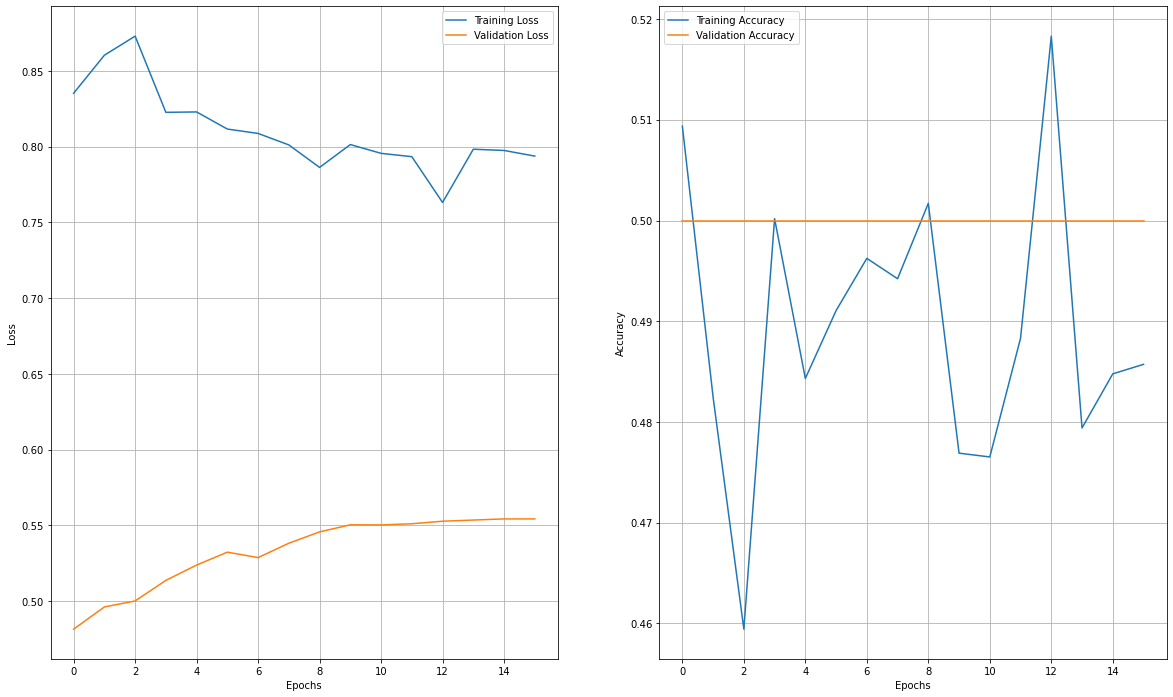

In [85]:
a=1
X = np.arange(0,len(result_Xception[a].history["loss"]),1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_Xception[a].history["loss"], label = "Training Loss")
plt.plot(X, result_Xception[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_Xception[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_Xception[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

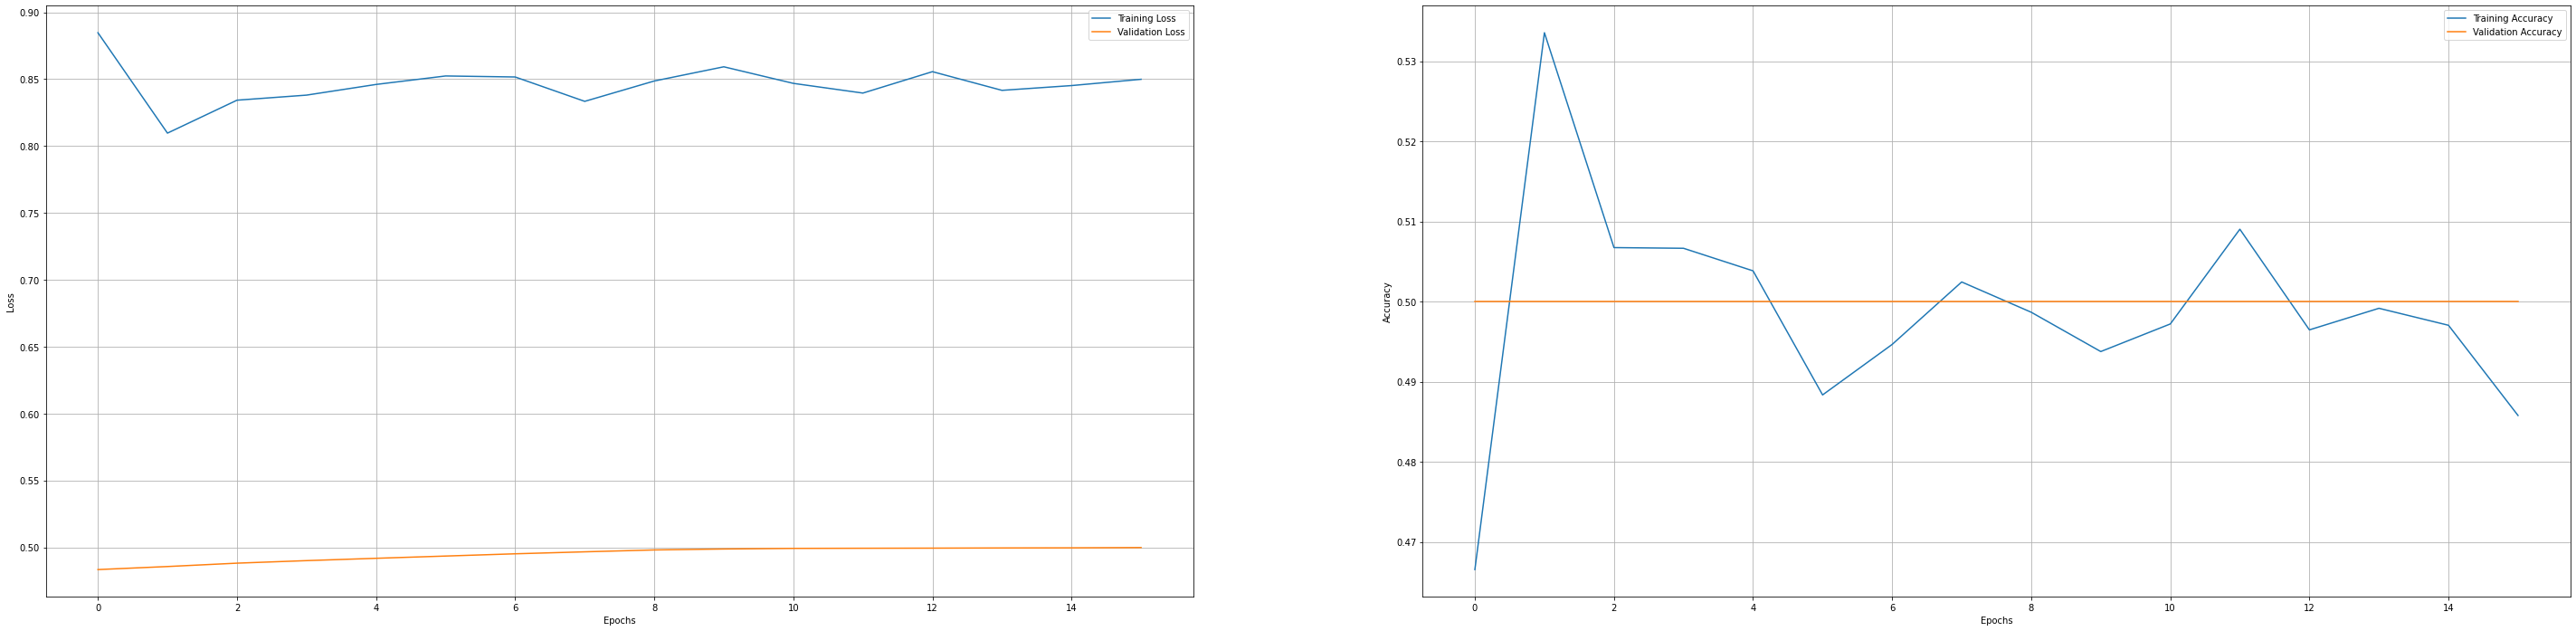

In [86]:
a=2
X = np.arange(0,len(result_Xception[a].history["loss"]),1)
plt.figure(1, figsize = (50, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, result_Xception[a].history["loss"], label = "Training Loss")
plt.plot(X, result_Xception[a].history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, result_Xception[a].history["auc"], label = "Training Accuracy")
plt.plot(X, result_Xception[a].history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

# Comparing the result from all the 5 models trained above:

In [89]:
list_result = {'epochs':[50,100,200],
              'VGG16':[result_VGG[0].history["auc"],result_VGG[1].history["auc"],result_VGG[2].history["auc"] ],
              'VGG19':[result_VGG19[0].history["auc"],result_VGG19[1].history["auc"],result_VGG19[2].history["auc"] ],
              'ResNet50':[result_ResNet50[0].history["auc"],result_ResNet50[1].history["auc"],result_ResNet50[2].history["auc"] ],
              'InceptionV3':[result_InceptionV3[0].history["auc"],result_InceptionV3[1].history["auc"],result_InceptionV3[2].history["auc"] ],
               'Xception':[result_Xception[0].history["auc"],result_Xception[1].history["auc"],result_Xception[2].history["auc"] ]
              }

result_df = pd.DataFrame(list_result)
result_df.set_index(['epochs'])
print(result_df)

   epochs                                              VGG16  \
0      50  [0.5342606902122498, 0.557216465473175, 0.5545...   
1     100  [0.6015286445617676, 0.6083191633224487, 0.620...   
2     200  [0.6379103660583496, 0.6296400427818298, 0.632...   

                                               VGG19  \
0  [0.5561138391494751, 0.605506420135498, 0.5428...   
1  [0.5827550888061523, 0.6191740036010742, 0.654...   
2  [0.6400335431098938, 0.6480358242988586, 0.630...   

                                            ResNet50  \
0  [0.5116791129112244, 0.498397558927536, 0.4842...   
1  [0.5134393572807312, 0.4896943271160126, 0.532...   
2  [0.4822421073913574, 0.4977518320083618, 0.520...   

                                         InceptionV3  \
0  [0.598087728023529, 0.6563024520874023, 0.5325...   
1  [0.6296281814575195, 0.6599986553192139, 0.681...   
2  [0.7734987735748291, 0.7446184754371643, 0.755...   

                                            Xception  
0  [0.4908857

Due to callbacks, best weights are automatically restored!

In [90]:
testing_dataset = get_test_dataset()
testing_dataset_images = testing_dataset.map(lambda image, image_name : image)
testing_image_names = testing_dataset.map(lambda image, image_name : image_name)

In [91]:
resulting_probabilities = model.predict(testing_dataset_images, verbose = 1)

86/86 [==============================] - 16s 185ms/step


In [92]:
len(resulting_probabilities)

10982

In [93]:
sample_submission_file = pd.read_csv("../input/siim-isic-melanoma-classification/sample_submission.csv")
sample_submission_file.head()

image_name  target
0  ISIC_0052060       0
1  ISIC_0052349       0
2  ISIC_0058510       0
3  ISIC_0073313       0
4  ISIC_0073502       0

In [97]:
del sample_submission_file["target"]
sample_submission_file.head()

image_name
0  ISIC_0052060
1  ISIC_0052349
2  ISIC_0058510
3  ISIC_0073313
4  ISIC_0073502

In [94]:
testing_image_names

<MapDataset shapes: (None,), types: tf.string>

In [95]:
testing_image_names = np.concatenate([x for x in testing_image_names], axis=0)
testing_image_names = np.array(testing_image_names)

In [96]:
decoded_test_names = []
for names in testing_image_names : 
    names = names.decode('utf-8')
    decoded_test_names.append(names)
decoded_test_names = np.array(decoded_test_names)
del testing_image_names

In [98]:
len(decoded_test_names), type(decoded_test_names), decoded_test_names.shape

(10982, numpy.ndarray, (10982,))

In [99]:
decoded_test_names

array(['ISIC_6381819', 'ISIC_5583376', 'ISIC_6408546', ...,
       'ISIC_8285611', 'ISIC_2076526', 'ISIC_8959686'], dtype='<U12')

In [100]:
testing_image_names = pd.DataFrame(decoded_test_names, columns=["image_name"])
testing_image_names.head()

image_name
0  ISIC_6381819
1  ISIC_5583376
2  ISIC_6408546
3  ISIC_6932354
4  ISIC_8191278

In [101]:
pred_dataframe = pd.DataFrame({"image_name" : decoded_test_names, 
                               "target" : np.concatenate(resulting_probabilities)})
pred_dataframe

image_name    target
0      ISIC_6381819  0.378319
1      ISIC_5583376  0.378319
2      ISIC_6408546  0.378319
3      ISIC_6932354  0.378319
4      ISIC_8191278  0.378319
...             ...       ...
10977  ISIC_1581247  0.378319
10978  ISIC_8432732  0.378319
10979  ISIC_8285611  0.378319
10980  ISIC_2076526  0.378319
10981  ISIC_8959686  0.378319

[10982 rows x 2 columns]

In [102]:
sample_submission_file = sample_submission_file.merge(pred_dataframe, on = "image_name")
sample_submission_file.to_csv("submission.csv", index = False)
sample_submission_file.head()

image_name    target
0  ISIC_0052060  0.378319
1  ISIC_0052349  0.378319
2  ISIC_0058510  0.378319
3  ISIC_0073313  0.378319
4  ISIC_0073502  0.378319

# Conclusion:- 
- Running on TPU's really increaed the processing of the models.
- Data Augmentation really helps in making the model robust. In these notebook we performed horizontal-flips, vertical-flips, cropping and Contrast Limited AHE (CLAHE) which really effective. 
- All CNN models performed well, but "InceptionV3" model performed best amongst all others.
- We figured out that, increasing the size of the model does not always help in increasing the performance. This problem is known as **Vanishing Gradient** problems. 